In [4]:
from google.colab import drive
drive.mount('/content/drive') # for google colab to access google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re

# Load our data paths
data_full_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/kddcup.data.gz'
test_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/corrected.gz'
names_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/kddcup.names'

# Build our dataframe
data = pd.read_csv(data_full_path, compression='gzip', header=None)
testset = pd.read_csv(test_path, compression='gzip', header=None)
names = pd.read_csv(names_path, skiprows=1, header=None, sep=':')
data.columns = names.iloc[:,0].tolist() + ['label']
testset.columns = names.iloc[:,0].tolist() + ['label']
data['label'] = data['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')
testset['label'] = testset['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')

print("unique labels in data:", data['label'].unique())
print("unique labels in testset:", testset['label'].unique())


data = data.drop_duplicates()
#testset = testset.drop_duplicates()

print("New Data Shape: ", data.shape)
print("New Test Set Shape: ", testset.shape)

X_train = data.drop(columns=['label'])
X_test = testset.drop(columns=['label'])
y_train = data['label']
y_test = testset['label']

print('\n\n\n')
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

# declare our categorical values
categorical_cols= ['protocol_type', 'service', 'flag']
boolean_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_guest_login', 'is_host_login']
cat_all = categorical_cols + boolean_cols
categorical_vars = cat_all



normalize_features = [
    'duration',
    'src_bytes',
    'dst_bytes',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'num_compromised',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'count',
    'serror_rate',
    'rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_count',
    'srv_serror_rate',
    'srv_rerror_rate',
    'srv_diff_host_rate'
]

def normalize_data(x_train, x_test, feature_list):
  scaler = MinMaxScaler()
  x_train[feature_list] = scaler.fit_transform(x_train[feature_list])
  x_test[feature_list] = scaler.transform(x_test[feature_list])
  return x_train, x_test

def convert_to_boolean(x_train, x_test, features_list):
  for feature in features_list:
    x_train[feature] = x_train[feature].astype(bool)
    x_test[feature] = x_test[feature].astype(bool)
  return x_train, x_test

# Standardize the numerical variables
#X_train, X_test = normalize_data(X_train, X_test, normalize_features)

#apply boolean
X_train, X_test = convert_to_boolean(X_train, X_test, boolean_cols)





# Helper function to convert a data row to textual format
def textualize(X_train, X_test, y_train=None, add_label=False):
    # Helper function to convert a data row to textual format
    def to_textual(data, labels=None):
        textual_data = []
        for index, row in enumerate(data.values):
            row_textual = [f"{col}: {val}" for col, val in zip(data.columns, row)]
            if add_label and labels is not None:
                row_textual.append(f"label: {labels.iloc[index]}")
            textual_data.append(' '.join(row_textual))
        return textual_data

    train_x_textual = to_textual(X_train, y_train if add_label else None)
    test_x_textual = to_textual(X_test)  # Labels typically not needed for test data in description generation

    return train_x_textual, test_x_textual



train_textual, test_textual = textualize(X_train, X_test)


def process_all_numbers(text):
    def f(match):
        num = match.group(0)
        integer_part = match.group(1)
        integer_length = len(integer_part)
        decimal_part = match.group(3)
        decimal_length = len(decimal_part) if decimal_part else 0

        if decimal_part:
            prefix = f'<sn>{integer_length}.{decimal_length}<mn>'
        else:
            prefix = f'<sn>{integer_length}<mn>'

        return prefix + num + '<en>'

    pattern = r'(\d+)(\.(\d+))?'
    return re.sub(pattern, f, text)

processed_text_train = []
processed_text_test = []

for string in train_textual:
    processed_string = process_all_numbers(string)
    processed_text_train.append(processed_string)

for string in test_textual:
    processed_string = process_all_numbers(string)
    processed_text_test.append(processed_string)

# Create DataFrames for training and test sets
data_ready_train = pd.DataFrame(processed_text_train, columns=['text'])
data_ready_test = pd.DataFrame(processed_text_test, columns=['text'])

# Ensure that indices are aligned before concatenation
data_ready_train.reset_index(drop=True, inplace=True)
data_ready_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Concatenate labels back into the DataFrames
data_ready_train['label'] = y_train
data_ready_test['label'] = y_test

# Strip any leading or trailing whitespace from labels
data_ready_train['label'] = data_ready_train['label'].str.strip()
data_ready_test['label'] = data_ready_test['label'].str.strip()

# Check for NaN values before mapping
print("NaN values in training labels before mapping:", data_ready_train['label'].isna().sum())
print("NaN values in test labels before mapping:", data_ready_test['label'].isna().sum())

# Map labels to integers
tag_mapping = {'normal': 0, 'attack': 1}
data_ready_train['label'] = data_ready_train['label'].map(tag_mapping)
data_ready_test['label'] = data_ready_test['label'].map(tag_mapping)

# Data check
data_ready_train['label'] = data_ready_train['label'].astype(int)
data_ready_test['label'] = data_ready_test['label'].astype(int)

print("FINAL DATA CHECK \n\n")
print(data_ready_train.head(2))
print(data_ready_test.head(2))

# Test train val split
x_train, x_val, y_train, y_val = train_test_split(data_ready_train['text'], data_ready_train['label'], test_size=0.2, random_state=42)
x_test = data_ready_test['text']
y_test = data_ready_test['label']

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

print(processed_text_train[0])
print(processed_text_test[0])

unique labels in data: ['normal' 'attack']
unique labels in testset: ['normal' 'attack']
New Data Shape:  (1074983, 42)
New Test Set Shape:  (311029, 42)




X_train Shape:  (1074983, 41)
X_test Shape:  (311029, 41)
y_train Shape:  (1074983,)
y_test Shape:  (311029,)
NaN values in training labels before mapping: 0
NaN values in test labels before mapping: 0
FINAL DATA CHECK 


                                                text  label
0  duration: <sn>1<mn>0<en> protocol_type: tcp se...      0
1  duration: <sn>1<mn>0<en> protocol_type: tcp se...      0
                                                text  label
0  duration: <sn>1<mn>0<en> protocol_type: udp se...      0
1  duration: <sn>1<mn>0<en> protocol_type: udp se...      0
(859986,) (859986,)
(214997,) (214997,)
(311029,) (311029,)
duration: <sn>1<mn>0<en> protocol_type: tcp service: http flag: SF src_bytes: <sn>3<mn>215<en> dst_bytes: <sn>5<mn>45076<en> land: False wrong_fragment: <sn>1<mn>0<en> urgent: <sn>1<mn>0<en> hot: <sn>

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
import tensorflow as tf

# Restrict TensorFlow to only use the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Optional: Set memory growth to prevent TensorFlow from reserving all GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define parameters
vocab_size = 88
sequence_length = 317

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad the sequences to ensure they are all the same length
x_train_padded = pad_sequences(x_train_seq, maxlen=sequence_length, padding='post')
x_val_padded = pad_sequences(x_val_seq, maxlen=sequence_length, padding='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=sequence_length, padding='post')


with normailization

Optimal vocab size for 99.0% coverage: 262


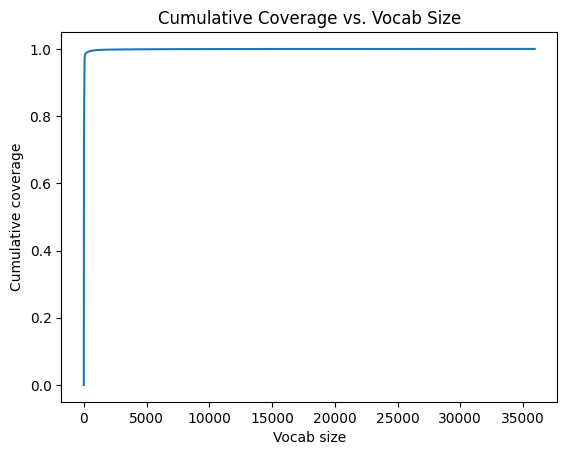

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the word counts
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
total_counts = sum(word_counts.values())

# Calculate cumulative coverage
cumulative_coverage = 0
coverage_threshold = 0.99
vocab_size_optimal = 0
for i, (word, count) in enumerate(sorted_word_counts):
    cumulative_coverage += count / total_counts
    if cumulative_coverage >= coverage_threshold:
        vocab_size_optimal = i + 1
        break

print(f"Optimal vocab size for {coverage_threshold*100}% coverage: {vocab_size_optimal}")

# Plot cumulative coverage
cumulative_coverage_list = [sum([count for _, count in sorted_word_counts[:i]]) / total_counts for i in range(len(sorted_word_counts))]
plt.plot(cumulative_coverage_list)
plt.xlabel('Vocab size')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative Coverage vs. Vocab Size')
plt.show()


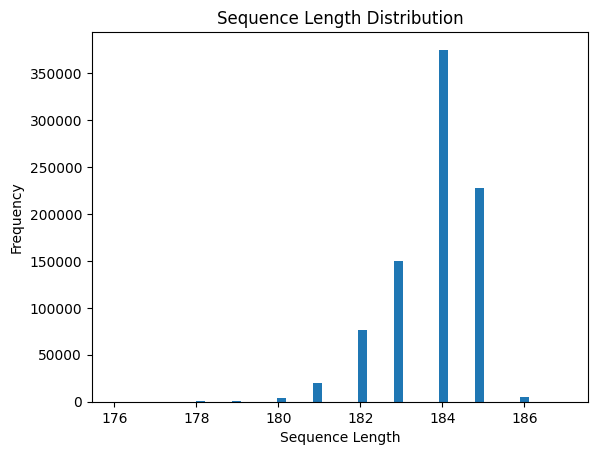

Optimal sequence length to cover 95% of data: 185


In [9]:
# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in x_train_seq]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# Choose optimal sequence length
sequence_length_optimal = int(np.percentile(sequence_lengths, 95))
print(f"Optimal sequence length to cover 95% of data: {sequence_length_optimal}")


without normalization

Optimal vocab size for 99.0% coverage: 195


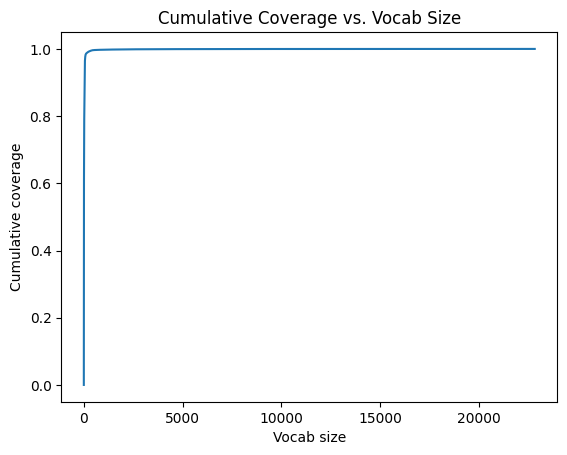

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the word counts
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
total_counts = sum(word_counts.values())

# Calculate cumulative coverage
cumulative_coverage = 0
coverage_threshold = 0.99
vocab_size_optimal = 0
for i, (word, count) in enumerate(sorted_word_counts):
    cumulative_coverage += count / total_counts
    if cumulative_coverage >= coverage_threshold:
        vocab_size_optimal = i + 1
        break

print(f"Optimal vocab size for {coverage_threshold*100}% coverage: {vocab_size_optimal}")

# Plot cumulative coverage
cumulative_coverage_list = [sum([count for _, count in sorted_word_counts[:i]]) / total_counts for i in range(len(sorted_word_counts))]
plt.plot(cumulative_coverage_list)
plt.xlabel('Vocab size')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative Coverage vs. Vocab Size')
plt.show()


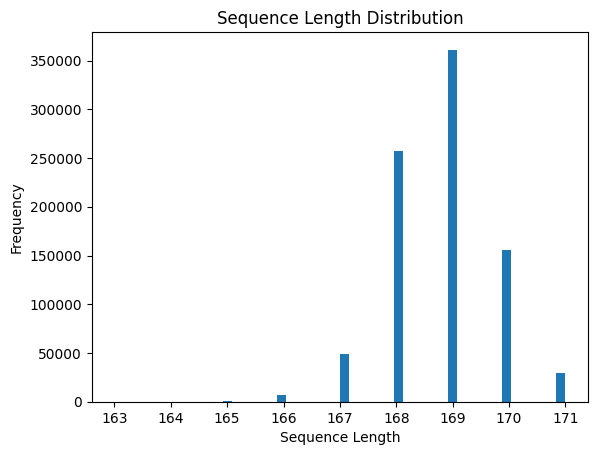

Optimal sequence length to cover 95% of data: 170


In [13]:
# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in x_train_seq]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# Choose optimal sequence length
sequence_length_optimal = int(np.percentile(sequence_lengths, 95))
print(f"Optimal sequence length to cover 95% of data: {sequence_length_optimal}")


numeric encode

Optimal vocab size for 99.0% coverage: 88


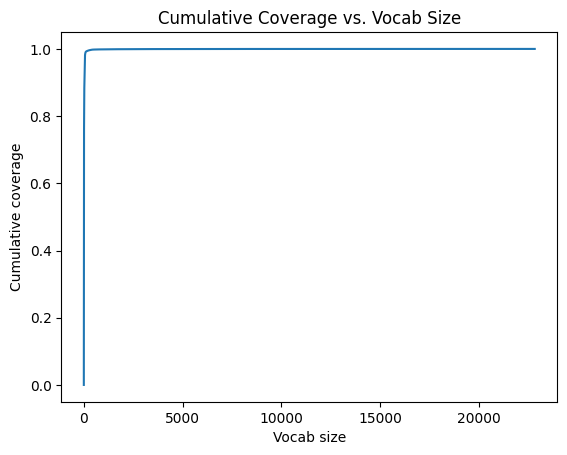

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the word counts
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
total_counts = sum(word_counts.values())

# Calculate cumulative coverage
cumulative_coverage = 0
coverage_threshold = 0.99
vocab_size_optimal = 0
for i, (word, count) in enumerate(sorted_word_counts):
    cumulative_coverage += count / total_counts
    if cumulative_coverage >= coverage_threshold:
        vocab_size_optimal = i + 1
        break

print(f"Optimal vocab size for {coverage_threshold*100}% coverage: {vocab_size_optimal}")

# Plot cumulative coverage
cumulative_coverage_list = [sum([count for _, count in sorted_word_counts[:i]]) / total_counts for i in range(len(sorted_word_counts))]
plt.plot(cumulative_coverage_list)
plt.xlabel('Vocab size')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative Coverage vs. Vocab Size')
plt.show()


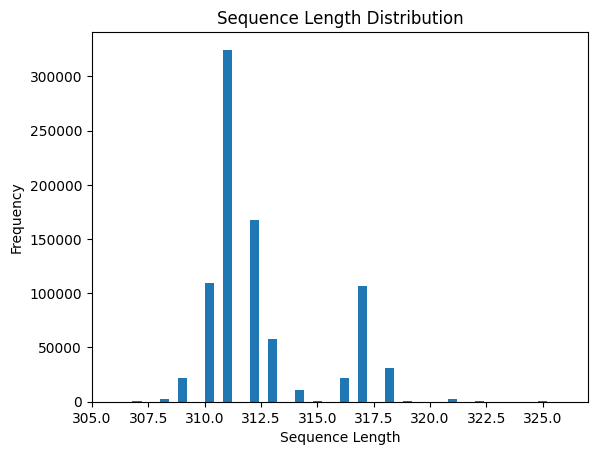

Optimal sequence length to cover 95% of data: 317


In [23]:
# Analyze sequence lengths
sequence_lengths = [len(seq) for seq in x_train_seq]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# Choose optimal sequence length
sequence_length_optimal = int(np.percentile(sequence_lengths, 95))
print(f"Optimal sequence length to cover 95% of data: {sequence_length_optimal}")


In [25]:
import tensorflow as tf

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_padded, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_padded, y_test)).batch(32)


In [2]:
!pip install --upgrade keras

In [3]:
# Update TensorFlow to the latest stable version
!pip install --upgrade tensorflow

# Verify the installation
import tensorflow as tf
print(tf.__version__)


2.17.0


with normalization

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Register the custom MaskComputationLayer
@keras.utils.register_keras_serializable()
class MaskComputationLayer(layers.Layer):
    def call(self, inputs):
        return tf.cast(tf.not_equal(inputs, 0), dtype=tf.int32)

# Register the custom PositionalEmbedding layer
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.mask_layer = MaskComputationLayer()

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return self.mask_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Register the custom TransformerEncoder layer
@keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Define model parameters
embed_dim = 256
num_heads = 2
dense_dim = 32

# Build the model
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length=185, input_dim=262, output_dim=embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

# Load the best model and evaluate
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding, "MaskComputationLayer": MaskComputationLayer})

print(f"Test accuracy: {model.evaluate(test_dataset)[1]:.3f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'transformer_encoder_1' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 256)      │        114,432 │ input_layer_2[0][0]    │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_computation_layer_1  │ (None, None)           │              0 │ input_layer_2[0][0]    │
│ (MaskComputationLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 256)      │        543,776 │ positional_embedding_… │
│ (TransformerEncoder)      │                        │                │ mask_computation_laye… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 256)            │              0 │ transformer_encoder_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            257 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 658,465 (2.51 MB)

 Trainable params: 658,465 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 365s 13ms/step - accuracy: 0.9951 - loss: 0.0178 - val_accuracy: 0.9990 - val_loss: 0.0048
Epoch 2/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 347s 13ms/step - accuracy: 0.9988 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 3/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 346s 13ms/step - accuracy: 0.9989 - loss: 0.0052 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 4/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 346s 13ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 0.9992 - val_loss: 0.0044
Epoch 5/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 346s 13ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9984 - val_loss: 0.0079


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


9720/9720 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9357 - loss: 0.9084
Test accuracy: 0.927


Train time ~4 hours, 17.2GB sys ram, 1.2GB gpu ram

In [11]:
# Generate predictions for the test set
predictions = model.predict(test_dataset)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)
# Assuming you have the true labels stored in `test_labels`
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_predictions))

9720/9720 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.98      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.94      0.93      0.93    311029



              precision    recall  f1-score   support

           0       0.73      0.98      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.94      0.93      0.93    311029



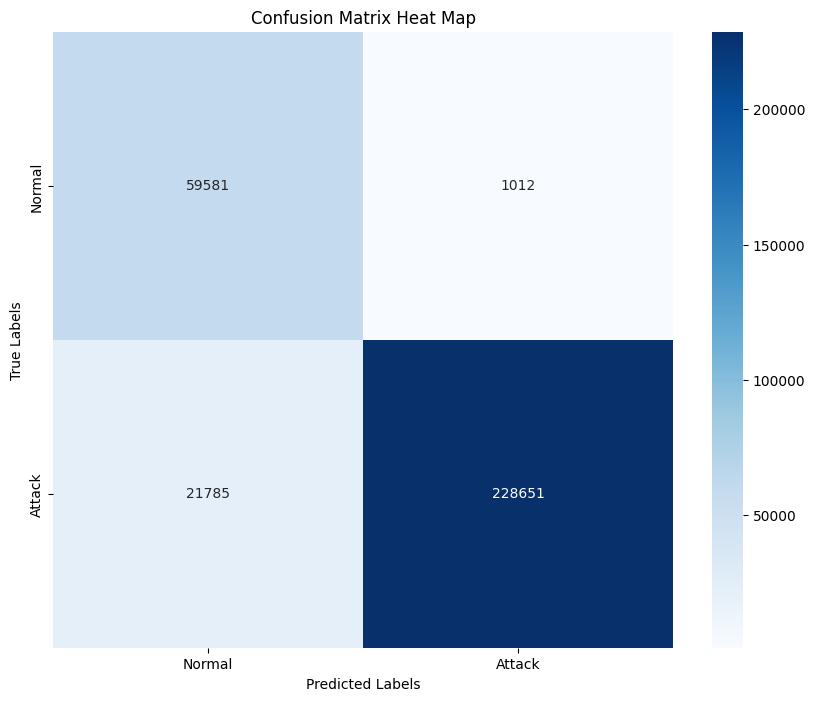

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Assuming you have the true labels stored in `y_test`
print(classification_report(y_test, binary_predictions))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heat Map')
plt.show()


without normalization

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Register the custom MaskComputationLayer
@keras.utils.register_keras_serializable()
class MaskComputationLayer(layers.Layer):
    def call(self, inputs):
        return tf.cast(tf.not_equal(inputs, 0), dtype=tf.int32)

# Register the custom PositionalEmbedding layer
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.mask_layer = MaskComputationLayer()

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return self.mask_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Register the custom TransformerEncoder layer
@keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Define model parameters
embed_dim = 256
num_heads = 2
dense_dim = 32

# Build the model
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length=170, input_dim=195, output_dim=embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

# Load the best model and evaluate
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding, "MaskComputationLayer": MaskComputationLayer})

print(f"Test accuracy: {model.evaluate(test_dataset)[1]:.3f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 256)      │         93,440 │ input_layer[0][0]      │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_computation_layer    │ (None, None)           │              0 │ input_layer[0][0]      │
│ (MaskComputationLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 256)      │        543,776 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ mask_computation_laye… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ transformer_encoder[0… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 637,473 (2.43 MB)

 Trainable params: 637,473 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


26875/26875 ━━━━━━━━━━━━━━━━━━━━ 334s 12ms/step - accuracy: 0.9956 - loss: 0.0168 - val_accuracy: 0.9991 - val_loss: 0.0044
Epoch 2/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 318s 12ms/step - accuracy: 0.9988 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 3/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 319s 12ms/step - accuracy: 0.9989 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 4/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 319s 12ms/step - accuracy: 0.9989 - loss: 0.0061 - val_accuracy: 0.9991 - val_loss: 0.0047
Epoch 5/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 320s 12ms/step - accuracy: 0.9985 - loss: 0.0071 - val_accuracy: 0.9988 - val_loss: 0.0071
Epoch 6/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 319s 12ms/step - accuracy: 0.9982 - loss: 0.0099 - val_accuracy: 0.9990 - val_loss: 0.0057


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


9720/9720 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9416 - loss: 1.0120
Test accuracy: 0.938


In [17]:
# Generate predictions for the test set
predictions = model.predict(test_dataset)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)
# Assuming you have the true labels stored in `test_labels`
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_predictions))

9720/9720 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step
              precision    recall  f1-score   support

           0       0.76      0.98      0.86     60593
           1       1.00      0.93      0.96    250436

    accuracy                           0.94    311029
   macro avg       0.88      0.95      0.91    311029
weighted avg       0.95      0.94      0.94    311029



              precision    recall  f1-score   support

           0       0.76      0.98      0.86     60593
           1       1.00      0.93      0.96    250436

    accuracy                           0.94    311029
   macro avg       0.88      0.95      0.91    311029
weighted avg       0.95      0.94      0.94    311029



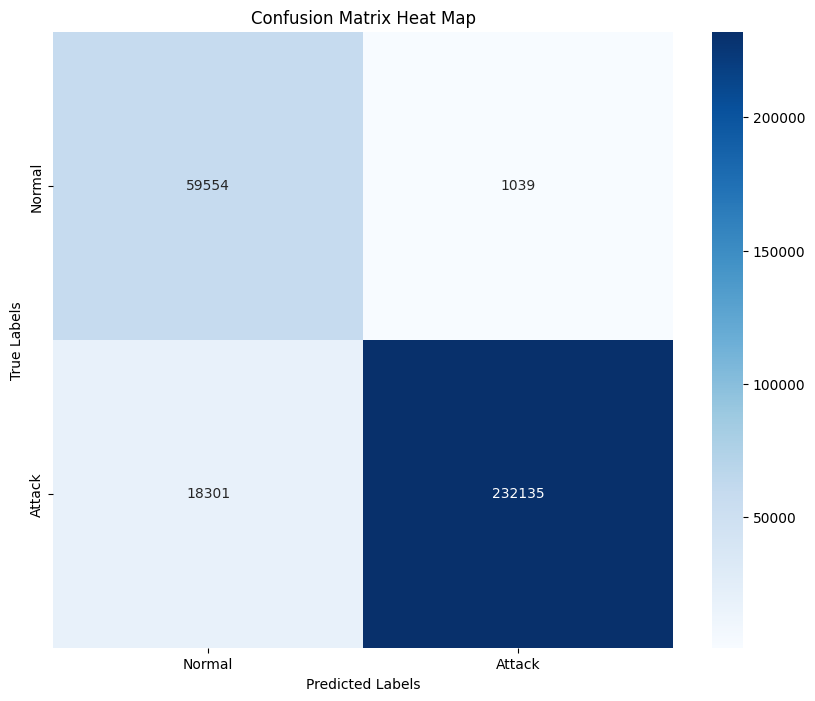

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Assuming you have the true labels stored in `y_test`
print(classification_report(y_test, binary_predictions))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heat Map')
plt.show()


numeric encode

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Register the custom MaskComputationLayer
@keras.utils.register_keras_serializable()
class MaskComputationLayer(layers.Layer):
    def call(self, inputs):
        return tf.cast(tf.not_equal(inputs, 0), dtype=tf.int32)

# Register the custom PositionalEmbedding layer
@keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.mask_layer = MaskComputationLayer()

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return self.mask_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# Register the custom TransformerEncoder layer
@keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Define model parameters
embed_dim = 256
num_heads = 2
dense_dim = 32

# Build the model
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length=170, input_dim=195, output_dim=embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

# Load the best model and evaluate
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding, "MaskComputationLayer": MaskComputationLayer})

print(f"Test accuracy: {model.evaluate(test_dataset)[1]:.3f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'transformer_encoder_1' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 256)      │         93,440 │ input_layer_3[0][0]    │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_computation_layer_2  │ (None, None)           │              0 │ input_layer_3[0][0]    │
│ (MaskComputationLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 256)      │        543,776 │ positional_embedding_… │
│ (TransformerEncoder)      │                        │                │ mask_computation_laye… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 256)            │              0 │ transformer_encoder_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            257 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 637,473 (2.43 MB)

 Trainable params: 637,473 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


26875/26875 ━━━━━━━━━━━━━━━━━━━━ 609s 22ms/step - accuracy: 0.9944 - loss: 0.0227 - val_accuracy: 0.9981 - val_loss: 0.0083
Epoch 2/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 590s 22ms/step - accuracy: 0.9973 - loss: 0.0126 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 3/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 592s 22ms/step - accuracy: 0.9969 - loss: 0.0132 - val_accuracy: 0.9984 - val_loss: 0.0073
Epoch 4/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 590s 22ms/step - accuracy: 0.9975 - loss: 0.0109 - val_accuracy: 0.9982 - val_loss: 0.0080
Epoch 5/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 590s 22ms/step - accuracy: 0.9974 - loss: 0.0126 - val_accuracy: 0.9981 - val_loss: 0.0090
Epoch 6/20
26875/26875 ━━━━━━━━━━━━━━━━━━━━ 590s 22ms/step - accuracy: 0.9975 - loss: 0.0118 - val_accuracy: 0.9975 - val_loss: 0.0103


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


9720/9720 ━━━━━━━━━━━━━━━━━━━━ 70s 7ms/step - accuracy: 0.9374 - loss: 0.7331
Test accuracy: 0.933


In [27]:
# Generate predictions for the test set
predictions = model.predict(test_dataset)
# Convert probabilities to binary predictions
binary_predictions = (predictions > 0.5).astype(int)
# Assuming you have the true labels stored in `test_labels`
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_predictions))

9720/9720 ━━━━━━━━━━━━━━━━━━━━ 66s 7ms/step
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.96      0.90    311029
weighted avg       0.95      0.93      0.94    311029



              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.96      0.90    311029
weighted avg       0.95      0.93      0.94    311029



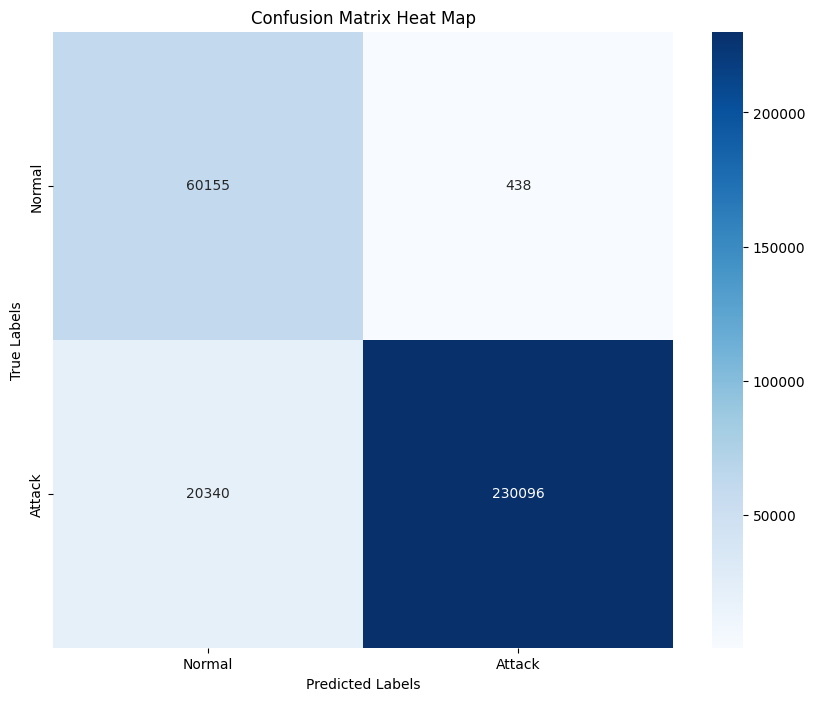

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report



# Assuming you have the true labels stored in `y_test`
print(classification_report(y_test, binary_predictions))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heat Map')
plt.show()
